# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
#merged dataset into dataframe for review.
data_measurement = pd.read_sql("Select * FROM Measurement", conn)
data_station = pd.read_sql("Select * FROM Station", conn)
merged_data=pd.merge(data_measurement, data_station, on="station")
merged_data.sort_values(by='date', ascending=False)

,id_x,station,date,prcp,tobs,id_y,name,latitude,longitude,elevation
19549,19550,USC00516128,2017-08-23,0.45,76.0,9,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
12186,12187,USC00519523,2017-08-23,0.08,82.0,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
2723,2724,USC00519397,2017-08-23,0.00,81.0,1,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7634,7635,USC00514830,2017-08-23,0.00,82.0,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
12185,12186,USC00519523,2017-08-22,0.00,82.0,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
...,...,...,...,...,...,...,...,...,...,...
14959,14960,USC00511918,2010-01-01,0.05,66.0,8,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
12187,12188,USC00519281,2010-01-01,0.15,70.0,7,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
9518,9519,USC00519523,2010-01-01,0.15,75.0,6,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
9007,9008,USC00518838,2010-01-01,0.21,72.0,5,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


# Exploratory Climate Analysis

In [8]:
#need query for last 12 months. plot of results.
#last date in data set is 8/23/2017.
precip_data_last12 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-24').filter(Measurement.date <= '2017-08-23').order_by(Measurement.date).all()
#select date and prcp from Measurement
#where date is between 2016-08-24 and 2017-08-23


In [9]:
#Create DataFrame with Data for Plotting
precip_data_df = pd.DataFrame(data=precip_data_last12).set_index('date')
precip_data_df.head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


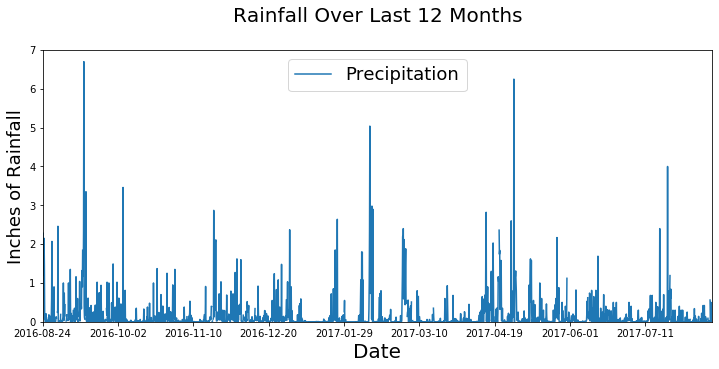

In [10]:
ax1 = precip_data_df.plot(figsize = (12,5))
ax1.set_title("Rainfall Over Last 12 Months\n", fontsize=20)
ax1.set_xlabel('Date', fontsize=20)
ax1.set_ylabel("Inches of Rainfall",fontsize = 18)
ax1.legend(labels=['Precipitation'], loc='upper center', fontsize = 18)
ax1.set_ylim([0,7])
plt.savefig('rainfall_last12_months.png')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_summary = precip_data_df.describe()
precip_data_summary

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
#find out the total stations in data set.
total_stations = session.query(Station.name).count()
#select name from Station
print(f'There are {total_stations} unique stations contained in this data set.')

There are 9 unique stations contained in this data set.


In [13]:
#need group by performed. Need to query with a group by station.
#query to group by station and grab count

most_active_stations = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
filter(Measurement.station == Station.station).\
group_by(Measurement.station)
#convert data into dataframe and then sort by descending.
most_active_stations_df = pd.DataFrame(data= most_active_stations, columns =['Station', 'Station Name','Count'])
most_active_stations_df.sort_values(by=['Count'], ascending=False)

,Station,Station Name,Count
6,USC00519281,"WAIHEE 837.5, HI US",2772
7,USC00519397,"WAIKIKI 717.2, HI US",2724
1,USC00513117,"KANEOHE 838.1, HI US",2709
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
4,USC00517948,"PEARL CITY, HI US",1372
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [15]:
#query for finding out the lowest temp in dataset.
#Select station, min(tobs) from Measurement;

lowest_temp = session.query(Measurement.station, Station.name, func.min(Measurement.tobs)).\
filter(Measurement.station==Station.station)
# lowest_temp[0]

highest_temp = session.query(Measurement.station, Station.name, func.max(Measurement.tobs)).\
filter(Measurement.station==Station.station)
print(f"Lowest Temperature observed in Dataset: {lowest_temp[0]}.\nHighest Temperature Observed in Dataset: {highest_temp[0]}.")

Lowest Temperature observed in Dataset: ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 53.0).
Highest Temperature Observed in Dataset: ('USC00519397', 'WAIKIKI 717.2, HI US', 87.0).


In [16]:
#most active station = USC00519281 at 2772 counts
#gets the average for the average temperature observed.

most_active_stations = session.query(Measurement.station, Station.name, func.avg(Measurement.tobs)).\
filter(Measurement.station==Station.station).\
group_by(Measurement.station).\
filter(Measurement.station == 'USC00519281')

most_active_stations[0][1]
print(f"The most active station is {most_active_stations[0][0]} which is located in {most_active_stations[0][1]}.\nThe average temperature of all data points captured is {round(most_active_stations[0][2])} degrees.")

The most active station is USC00519281 which is located in WAIHEE 837.5, HI US.
The average temperature of all data points captured is 72 degrees.


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#most active USC00519281, need last 12 months in query, need temperature for the last 12 months. plot.

In [18]:
#query to collect all information on temperature points from last 12 months.
station_year_temp = session.query(Measurement.station, Station.name, Measurement.date, Measurement.tobs).\
filter(Measurement.station == Station.station).\
filter(Measurement.station =='USC00519281').\
filter(Measurement.date >= '2016-08-24').\
filter(Measurement.date <= '2017-08-23').\
order_by(Measurement.date).all()

In [19]:
#convert all data captured in query into a dataframe for plotting purposes.
usc00519281_df = pd.DataFrame(data= station_year_temp, columns =['Station', 'Station Name','Date', 'Temperature'])
usc00519281_df

,Station,Station Name,Date,Temperature
0,USC00519281,"WAIHEE 837.5, HI US",2016-08-24,77.0
1,USC00519281,"WAIHEE 837.5, HI US",2016-08-25,80.0
2,USC00519281,"WAIHEE 837.5, HI US",2016-08-26,80.0
3,USC00519281,"WAIHEE 837.5, HI US",2016-08-27,75.0
4,USC00519281,"WAIHEE 837.5, HI US",2016-08-28,73.0
...,...,...,...,...
346,USC00519281,"WAIHEE 837.5, HI US",2017-08-14,77.0
347,USC00519281,"WAIHEE 837.5, HI US",2017-08-15,77.0
348,USC00519281,"WAIHEE 837.5, HI US",2017-08-16,76.0
349,USC00519281,"WAIHEE 837.5, HI US",2017-08-17,76.0


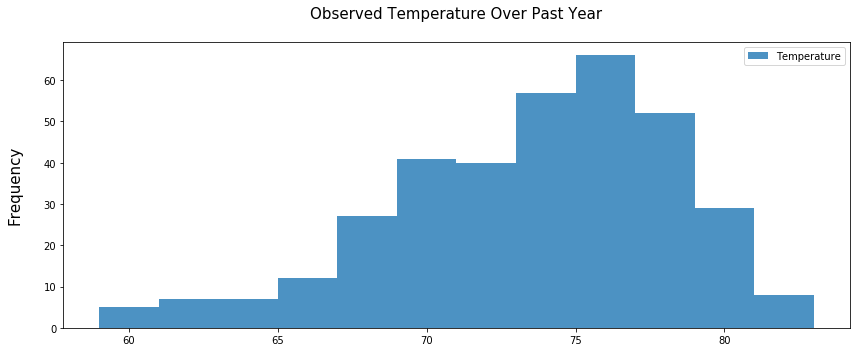

In [20]:
#plot a histogram of the dataframe made.
ax2= usc00519281_df.plot.hist(bins=12, alpha=.8, figsize=(12,5))
ax2.set_title('Observed Temperature Over Past Year\n', fontsize = 15)
ax2.set_ylabel('Frequency\n',fontsize = 15)
plt.tight_layout()
plt.savefig('Observed_Temperature.png')

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#inserted dates taken from previous dataframe made.
trip_dates = (calc_temps('2016-08-24', '2017-08-18'))
trip_min = trip_dates[0][0]
trip_avg = trip_dates[0][1]
trip_max = trip_dates[0][2]

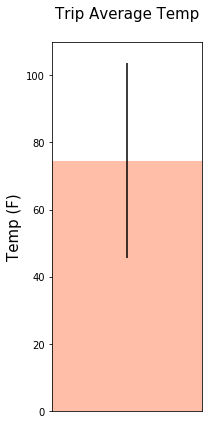

In [23]:
#plot standard error from min avg and max temps in trip_dates
standard_error = trip_max - trip_min
fig,ax3 = plt.subplots(figsize = (3,6))
ax3.set_ylabel('Temp (F)', fontsize = 15)
ax3.set_title('Trip Average Temp\n', fontsize = 15)
ax3.bar(0,trip_avg, width=.10, alpha=.5, color='coral', yerr = standard_error)
ax3.set_xlim(0,5)
ax3.set_ylim(0,110)
ax3.set_xbound(lower=-0.05, upper=.05)
ax3.set_xticks([])
plt.tight_layout()
plt.savefig('trip_avg_temp.png')

In [71]:
#define items to join and place in query

selectors= [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]

test = session.query(*selectors).\
filter(Measurement.station==Station.station).\
filter(Measurement.date >= '2016-08-24').\
filter(Measurement.date <= '2017-08-18').\
group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()


In [72]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    selectors= [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]

    return session.query(*selectors).\
    filter(Measurement.station==Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

# function usage example
print(rainfall('2016-08-24', '2017-08-18'))

[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.28), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.15), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.15), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.45), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 1.22), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [73]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
